# Part I: Federated Learning in a Nutshell

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/leolavaur/icdcs_2024/blob/main/notebooks/part1.ipynb)

In this first part, we will go over the basic concepts of experimenting with federated learning (FL), using the Flower framework, and TensorFlow as the machine learning (ML) backend.
We will see how we can leverage Flower's simulation capabilities to run a horizontal FL experiment in cross-device setting, using the MNIST dataset and a simple convolutional model.

## Section 0: Prerequisites

### Dependencies

> Be advised that Google collab currently does not support the latest versions of Python (limited to 3.10).
> However, some packages required in these notebooks require Python 3.11 or higher.
> Therefore, we recommend running these notebooks locally.

Once you have a working environment, check that everything works, notably your GPU for the TensorFlow backend.
You can do so by running the following cell:


In [35]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.17.0
Num GPUs Available: 1


To allow others to reproduce your results with some degree of certitude, set a seed for all the pseudo-random number generators (PRNG) that you use.
You should also run your threads deterministically, in case your ML backend optimize training.
This will have a negative impact on the performance.
On TensorFlow: 

In [36]:
import keras


def set_seed(seed: int):
    """Set seed for reproducibility."""
    keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()


set_seed(42)

### Section 1: Data exploration and partitioning

MNIST is a basic datasets often use as an easy benchmark for computer-vision algorithms.
It contains 28x38 grayscale pictures of handwritten digits (from 0 to 9).
One typical task is to classify each digit to its corresponding class.

The dataset is bundled in a lot of ML frameworks, including TensorFlow.
However, Huggingface's user-friendly `datasets` library provides a more convenient way to load it.
It is also well-integrated with Flower, which we will use later on.
Let's load the dataset and explore it a bit.

In [37]:
from typing import cast

from datasets import DatasetDict, load_dataset

ds = cast(DatasetDict, load_dataset("ylecun/mnist"))
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

Let's look at some samples from the dataset.

In [38]:
import matplotlib.pyplot as plt

trainset = ds["train"]
example = trainset[0]
example

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 5}

In [39]:
example["image"]

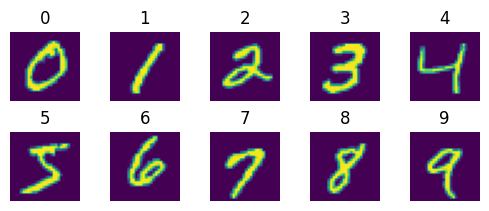

In [40]:
import numpy as np
from matplotlib.axes import Axes

fig, axs = plt.subplots(2, 5, figsize=(5, 2), constrained_layout=True)
assert isinstance(axs, np.ndarray)
for i, ax in enumerate(axs.flatten()):
    ax: Axes
    ex = next((ex for ex in trainset if ex["label"] == i))
    ax.imshow(ex["image"])
    ax.axis("off")
    ax.set_title(str(i))

The dataset associates each image with a label, which is the digit it represents, from 0 to 9.
Deep learning models can be trained to predict these labels from the images, as a list of integers.
However, it might be more interesting to train a model that can give a probability distribution over the classes, which is more informative.

To do so, we commonly rely on one-hot encoding, where each label is represented as a vector of zeros, except for the index corresponding to the label, which is set to 1.
Additionally, we will normalize the images to have pixel values between 0 and 1, which typically improves the training of deep learning models.

In [41]:
import numpy as np
from datasets import Array2D, ClassLabel, Sequence, Value
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(categories=[list(range(10))])


def preprocess(example):
    example["pixels"] = np.array(example["image"]) / 255.0
    example["onehot_label"] = np.zeros(10, dtype=np.float32)
    example["onehot_label"][example["label"]] = 1.0

    return example


new_features = ds["train"].features.copy()
new_features["pixels"] = Array2D(shape=(28, 28), dtype="float32")
new_features["onehot_label"] = Sequence(feature=Value(dtype="float32"), length=10)
ds = ds.map(preprocess, num_proc=4).cast(new_features)

In [42]:
ds["train"].features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], id=None),
 'pixels': Array2D(shape=(28, 28), dtype='float32', id=None),
 'onehot_label': Sequence(feature=Value(dtype='float32', id=None), length=10, id=None)}

In [43]:
ds["train"][0]["onehot_label"]

[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]

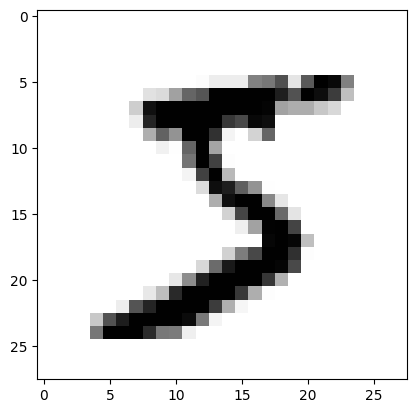

In [44]:
plt.imshow(ds["train"][0]["pixels"], cmap="gray_r")

Training a model means finding the best parameters for it, so that it can correctly classify the
data. This is done by minimizing a loss function, which is a measure of how well the model performs
on the training data. The loss function is computed on the training data, and the model is updated
to minimize it. This process is repeated until the loss function converges to a local minimum.

MNIST is an "easy" problem, with low-dimensional images and a small number of classes. A simple deep-learning model architecture suffices to obtain relevant results.

In [45]:
def mk_model() -> keras.Model:
    """Create a simple DNN model for MNIST classification."""
    model = keras.models.Sequential(
        [
            keras.layers.Input(shape=(28, 28)),
            keras.layers.Flatten(),
            keras.layers.Dense(128, activation="relu"),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(10, activation="softmax"),
        ]
    )

    model.compile(
        loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )

    return model


mk_model().summary()

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_25 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

We will use the `fit` method of the Keras model to train it over a few epochs.
We can also play around with the batch size, which defines how frequently the model is updated.


Note: a smaller batch size will result in more steps per epoch, and therefore a longer training time. 

We use the TensorFlow backend to train the model, and therefore rely on TensorFlow's data loading and preprocessing utilities. The `to_dataset` method of 🤗 converts the `Dataset` instance into a TensorFlow *prefetched* dataset, which offers great performance.

In [46]:
BATCH_SIZE = 256
EPOCHS = 5

trainset = ds["train"].to_tf_dataset(
    columns="pixels", label_cols="onehot_label", batch_size=BATCH_SIZE
)

testset = ds["test"].to_tf_dataset(
    columns="pixels", label_cols="onehot_label", batch_size=BATCH_SIZE
)

model = mk_model()
hist = model.fit(trainset, epochs=EPOCHS)

Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.7602 - loss: 0.8367
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9281 - loss: 0.2533
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9460 - loss: 0.1886
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9560 - loss: 0.1545
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9618 - loss: 0.1341


In [47]:
model.evaluate(testset)

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9607 - loss: 0.1294


[0.10910402983427048, 0.9668999910354614]

## Section 2: Local training

To train a federation of devices one needs to partition the dataset into multiple subsets, one for each device. Partitions are sometimes referred to as shards, one shard of the training set per client.

For research purposes, as we have the entire dataset, we can use one testing set to evaluate the performance of the model. In a real-world scenario, we would not have access to the testing set, and each client would have to evaluate the model on its own data.

In [48]:
from flwr_datasets.partitioner import IidPartitioner

NUM_CLIENTS = 10

partitioner = IidPartitioner(num_partitions=NUM_CLIENTS)
partitioner.dataset = ds["train"]

train_0 = partitioner.load_partition(0)
train_0

Dataset({
    features: ['image', 'label', 'pixels', 'onehot_label'],
    num_rows: 6000
})

Flower, the FL framework leveraged in this example also provides a utility to partition the dataset into shards, using Huggingface's `datasets` library.
We can use it to visualize the distribution of the data across the clients.

A first example is IID partitioning, where the data is distributed uniformly across the clients.
This means that each shard contains a similar data distribution.

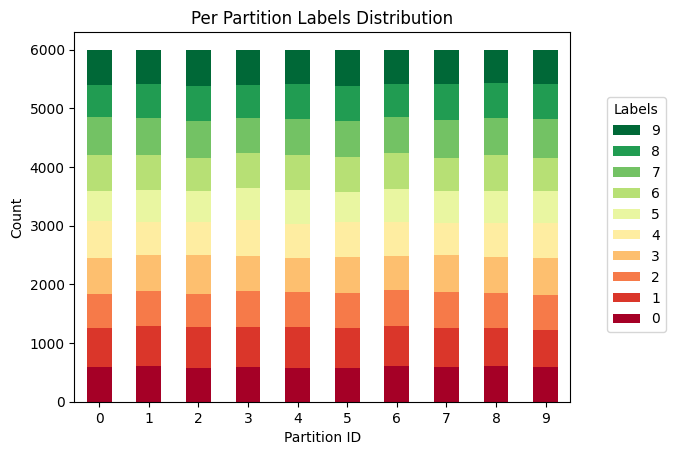

In [49]:
from flwr_datasets.visualization import plot_label_distributions

_ = plot_label_distributions(
    partitioner,
    label_name="label",
    plot_type="bar",
    size_unit="absolute",
    partition_id_axis="x",
    legend=True,
    verbose_labels=True,
    title="Per Partition Labels Distribution",
)

The `flwr_dataset` library also provides other partitioning strategies, to simulate non-IID data distribution.
Some examples include:

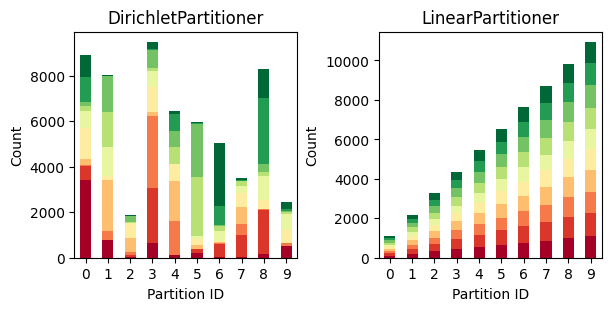

In [50]:
from flwr_datasets.partitioner import DirichletPartitioner, LinearPartitioner

fig = plt.figure(figsize=(6, 3), constrained_layout=True)
axs = fig.subplots(1, 2)

partitioner = DirichletPartitioner(
    num_partitions=NUM_CLIENTS, partition_by="label", alpha=0.5
)
partitioner.dataset = ds["train"]
_ = plot_label_distributions(
    partitioner, label_name="label", axis=axs[0], title="DirichletPartitioner"
)

partitioner = LinearPartitioner(num_partitions=NUM_CLIENTS)
partitioner.dataset = ds["train"]
_ = plot_label_distributions(
    partitioner, label_name="label", axis=axs[1], title="LinearPartitioner"
)

Let's test training a model on a single client, to see how well it performs on the training data.

In [51]:
# Model / data parameters

NUM_CLIENTS = 100

partitioner = IidPartitioner(num_partitions=NUM_CLIENTS)
partitioner.dataset = ds["train"]

train_0 = partitioner.load_partition(0)
train_0

Dataset({
    features: ['image', 'label', 'pixels', 'onehot_label'],
    num_rows: 600
})

Increasing the number of clients will logically reduce the number of samples per client.

In [52]:
EPOCHS = 10

train_0 = train_0.to_tf_dataset(
    columns="pixels", label_cols="onehot_label", batch_size=BATCH_SIZE
)

model = mk_model()
hist = model.fit(train_0, epochs=EPOCHS)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.1310 - loss: 2.3210
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4800 - loss: 1.9043
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6759 - loss: 1.5803
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7666 - loss: 1.3167
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7924 - loss: 1.0933
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8022 - loss: 0.9302
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8271 - loss: 0.7822
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8496 - loss: 0.6795
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8412 - loss: 0.6153
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8718 - loss: 0.5425


In [53]:
testset = ds["test"].to_tf_dataset(
    columns="pixels", label_cols="onehot_label", batch_size=BATCH_SIZE
)

loss, accuracy = model.evaluate(testset)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7714 - loss: 0.7754
Test loss: 0.6797348856925964
Test accuracy: 0.8070999979972839


## Part 3: Federated learning

We use Flower to train our federated model.
In federated learning, the model is trained on multiple clients, which are usually distributed across the network.
Each client has a local dataset, and the model is trained on it.
The model is then sent to the server, which aggregates the updates and sends them back to the clients.

The clients then apply the updates to their local model, and the process is repeated.
We call this cycle a round.

The `flwr` library is a Python implementation of FL.
It provides a set of tools to implement a
federated learning in simulations, as well as in real-world applications.
It is designed to be easy
to use, and to be compatible with a wide range of ML frameworks, including Tensorflow/Keras.

Its main components are:
- `flwr.client`: contains the `Client` class, which represents a client in the FL process.
  It provides a set of methods that are called by the server during the training process.
  The client can be simulated using `ray`, or run on a real device.
- `flwr.server`: contains the `Server` class, which represents the server in the FL process.
  It acts as a coordinator, and is responsible for managing the training process.

- `flwr.strategy`: contains the implementation of the aggregation algorithm.
  `FedAvg` is the most common algorithm, and is the one we will use in this tutorial, but `flwr` also provides other strategies, such as `FedProx`, `FedOpt`, `FedYogi`, `FedAdagrad`, and `FedAdam`.

Below is a diagram of `flwr`'s architecture, you can find more information in the [documentation](https://flower.dev/docs/architecture.html).

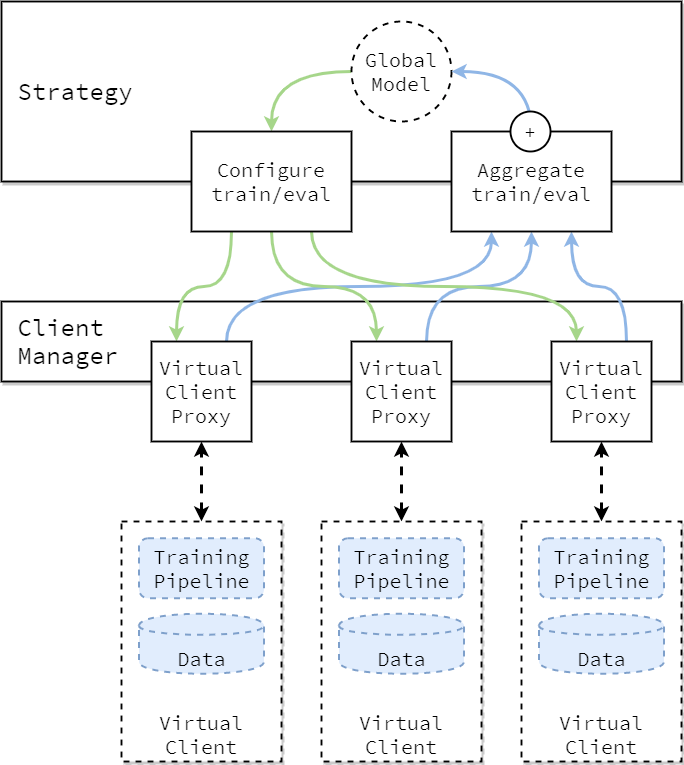


We first create a `flwr` client, which is a wrapper around the Keras model.
The client is responsible for training the model on its local dataset, and for sending the updates to the server.

In [55]:
import flwr as fl
import tensorflow as tf


class FlowerClient(fl.client.NumPyClient):
    def __init__(self, trainset: tf.data.Dataset):
        self.model = mk_model()
        self.trainset = trainset

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(self.trainset, epochs=1)
        return self.model.get_weights(), len(self.trainset), {}

We can write a few helper functions to create the client, and associate it with a dataset.
Other fonctions can be made to customize the FL process, such as how models are aggregated, or how the clients are selected.

In [56]:
from typing import Callable

from flwr.client import Client
from flwr_datasets.partitioner import Partitioner


def mk_client_fn(
    partitioner: Partitioner,
) -> Callable[[str], Client]:
    """Return a function which creates a new Client for a given partition."""

    def client_fn(cid: str) -> Client:
        """Create a new Client for partition i."""
        client_dataset = partitioner.load_partition(int(cid))
        client_dataset = client_dataset.to_tf_dataset(
            columns="pixels", label_cols="onehot_label", batch_size=BATCH_SIZE
        )
        return FlowerClient(trainset=client_dataset).to_client()

    return client_fn


def weighted_average(
    metrics: list[tuple[int, dict[str, int | float]]],
) -> dict[str, int | float | str]:
    """Aggregate metrics using a weighted average based on data size."""
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}


def get_evaluate_fn(testset):
    """Return an evaluation function for server-side (i.e. centralised) evaluation."""

    # The `evaluate` function will be called after every round by the strategy
    def evaluate(
        server_round: int,
        parameters: fl.common.NDArrays,
        config: dict[str, fl.common.Scalar],
    ):
        model = mk_model()  # Construct the model
        model.set_weights(parameters)  # Update model with the latest parameters
        loss, accuracy = model.evaluate(testset)
        return loss, {"accuracy": accuracy}

    return evaluate

Let's create a federated learning simulation with Flower, using the MNIST dataset and our simple model.

In [57]:
from flwr.simulation.ray_transport.utils import enable_tf_gpu_growth

NUM_CLIENTS = 100

# Enable GPU growth in the main process
enable_tf_gpu_growth()


def init_fn():
    # Enable GPU growth in the worker processes
    enable_tf_gpu_growth()
    set_seed(42)


# Create dataset partitions (needed if your dataset is not pre-partitioned)
trainset = ds["train"]
partitioner = IidPartitioner(num_partitions=NUM_CLIENTS)
partitioner.dataset = trainset
centralized_testset = ds["test"].to_tf_dataset(
    columns="pixels", label_cols="onehot_label", batch_size=BATCH_SIZE
)

# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=0.1,  # Sample 10% of available clients for training
    fraction_evaluate=0,  # Disable federated evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    # min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=int(
        NUM_CLIENTS * 0.75
    ),  # Wait until at least 75 clients are available
    evaluate_fn=get_evaluate_fn(testset),  # global evaluation function
)

# With a dictionary, you tell Flower's VirtualClientEngine that each
# client needs exclusive access to these many resources in order to run
client_resources = {"num_cpus": 1, "num_gpus": 0.25}

# Start simulation
history = fl.simulation.start_simulation(
    client_fn=mk_client_fn(partitioner),
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=10),
    strategy=strategy,
    client_resources=client_resources,
    actor_kwargs={
        "on_actor_init_fn": init_fn  # Enable GPU growth upon actor init.
    },
    ray_init_args={"num_gpus": len(tf.config.list_physical_devices("GPU"))},
)

INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2024-07-21 08:50:48,378	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'memory': 7066363495.0, 'GPU': 1.0, 'node:127.0.0.1': 1.0, 'CPU': 8.0, 'node:__internal_head__': 1.0, 'object_store_memory': 2147483648.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.25}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 4 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(ClientAppActor pid=65245) 2024-07-21 08:50:54.004092: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
(ClientAppActor pid=65245) 2024-07-21 08:50:54.004128: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
(ClientAppActor pid=6

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0852 - loss: 2.3838


INFO :      initial parameters (loss, other metrics): 2.365307331085205, {'accuracy': 0.09260000288486481}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)
(ClientAppActor pid=65245) 2024-07-21 08:50:55.436430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 921ms/step - accuracy: 0.1094 - loss: 2.3683
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.1172 - loss: 2.3393 
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.1369 - loss: 2.3094
1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 836ms/step - accuracy: 0.1328 - loss: 2.3191
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.1765 - loss: 2.2632
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.1412 - loss: 2.2859
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.1641 - loss: 2.3061


INFO :      aggregate_fit: received 10 results and 0 failures


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.1458 - loss: 2.2954
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4063 - loss: 2.0453


INFO :      fit progress: (1, 2.0036065578460693, {'accuracy': 0.44449999928474426}, 6.179217875003815)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)
(ClientAppActor pid=65245) WARNING:tensorflow:5 out of the last 13 calls to <function TensorFlowTrainer.make_train_function.<locals>.one_step_on_iterator at 0x3c5274180> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function fo

1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step - accuracy: 0.3750 - loss: 2.0286 [repeated 9x across cluster]
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.1309 - loss: 2.3204 [repeated 3x across cluster]
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.1582 - loss: 2.2730 [repeated 2x across cluster]
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.4381 - loss: 1.9582
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.3830 - loss: 1.9744


(ClientAppActor pid=65245) WARNING:tensorflow:5 out of the last 13 calls to <function TensorFlowTrainer.make_train_function.<locals>.one_step_on_iterator at 0x3cbef42c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.1279 - loss: 2.3114 [repeated 4x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures


2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.1396 - loss: 2.2925 [repeated 2x across cluster]
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6095 - loss: 1.7631


INFO :      fit progress: (2, 1.7059522867202759, {'accuracy': 0.6478999853134155}, 10.090572916989913)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)
(ClientAppActor pid=65244) WARNING:tensorflow:5 out of the last 13 calls to <function TensorFlowTrainer.make_train_function.<locals>.one_step_on_iterator at 0x388f6fb00> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function fo

1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step - accuracy: 0.5742 - loss: 1.7441 [repeated 16x across cluster]
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4473 - loss: 1.9586 
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.4545 - loss: 1.9432
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.5957 - loss: 1.6946 [repeated 11x across cluster]
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.6525 - loss: 1.6288
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.5422 - loss: 1.7306


INFO :      aggregate_fit: received 10 results and 0 failures


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.5363 - loss: 1.7385
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.5932 - loss: 1.6986
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6810 - loss: 1.5178


INFO :      fit progress: (3, 1.4505670070648193, {'accuracy': 0.718999981880188}, 15.303303291992052)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.6522 - loss: 1.5311 
1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 874ms/step - accuracy: 0.6875 - loss: 1.4752 [repeated 6x across cluster]
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.6561 - loss: 1.4683 [repeated 4x across cluster]
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6719 - loss: 1.4269
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6387 - loss: 1.4960
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.6701 - loss: 1.4334


INFO :      aggregate_fit: received 10 results and 0 failures


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.6546 - loss: 1.5241
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7249 - loss: 1.3015


INFO :      fit progress: (4, 1.2275457382202148, {'accuracy': 0.7651000022888184}, 19.733763166994322)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6924 - loss: 1.4298 
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7080 - loss: 1.2371 
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.6605 - loss: 1.3341
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.7248 - loss: 1.2308


INFO :      aggregate_fit: received 10 results and 0 failures


1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step - accuracy: 0.6914 - loss: 1.3167 [repeated 15x across cluster]
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.7478 - loss: 1.2456 [repeated 9x across cluster]
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.7115 - loss: 1.2081 [repeated 3x across cluster]
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7535 - loss: 1.1226


INFO :      fit progress: (5, 1.0462172031402588, {'accuracy': 0.7914999723434448}, 23.97290162500576)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8096 - loss: 0.9743
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6826 - loss: 1.2511 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6529 - loss: 1.3335  [repeated 3x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.6521 - loss: 1.3324 [repeated 2x across cluster]
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7847 - loss: 0.9806


INFO :      fit progress: (6, 0.9030856490135193, {'accuracy': 0.8184000253677368}, 28.60513945898856)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


1/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.7852 - loss: 0.9134 [repeated 9x across cluster]
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.7531 - loss: 0.9896 [repeated 4x across cluster]
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.7499 - loss: 1.0330 [repeated 7x across cluster]
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7422 - loss: 1.0758 [repeated 6x across cluster]
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7959 - loss: 0.9390 [repeated 4x across cluster]
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.7361 - loss: 1.0699
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.7309 - loss: 1.0712


INFO :      aggregate_fit: received 10 results and 0 failures


1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.7266 - loss: 1.1362 [repeated 7x across cluster]
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.7896 - loss: 0.9378 [repeated 5x across cluster]
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7995 - loss: 0.8718


INFO :      fit progress: (7, 0.7954285144805908, {'accuracy': 0.8302000164985657}, 36.160834708978655)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.7317 - loss: 1.0774
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.7360 - loss: 1.1020 [repeated 3x across cluster]
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7412 - loss: 0.9417
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.7354 - loss: 1.0170
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.7464 - loss: 0.9305
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 256ms/step - accuracy: 0.7787 - loss: 0.8794 [repeated 4x across cluster]
1/3 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - accuracy: 0.7500 - loss: 0.8870 [repeated 4x across cluster]
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.7551 - loss: 0.8758 [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.8020 - loss: 0.8052 [repeated 4x across cluster]
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8320 - loss: 0.7713 [repeated 2x across cluster]
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7520 - loss: 0.8798
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8241 - loss: 0.7822


INFO :      fit progress: (8, 0.7105646729469299, {'accuracy': 0.8496000170707703}, 44.568953791982494)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.7419 - loss: 1.0103
1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step - accuracy: 0.8594 - loss: 0.6310 [repeated 5x across cluster]
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7617 - loss: 0.8219 
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.8271 - loss: 0.6927
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.7684 - loss: 0.8228
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.7492 - loss: 0.8951
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.7975 - loss: 0.7655


INFO :      aggregate_fit: received 10 results and 0 failures


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.8389 - loss: 0.6456 [repeated 3x across cluster]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7989 - loss: 0.7646 [repeated 2x across cluster]
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.7578 - loss: 0.8789
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8344 - loss: 0.7140


INFO :      fit progress: (9, 0.6445972919464111, {'accuracy': 0.8590999841690063}, 49.37012512498768)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


1/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.7578 - loss: 0.7766 [repeated 11x across cluster]
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8271 - loss: 0.7348
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.8082 - loss: 0.7700
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.8269 - loss: 0.7365


INFO :      aggregate_fit: received 10 results and 0 failures


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.7626 - loss: 0.7959
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8417 - loss: 0.6615


INFO :      fit progress: (10, 0.5932775139808655, {'accuracy': 0.8637999892234802}, 53.85569570900407)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 53.86s
INFO :      	History (loss, centralized):
INFO :      		round 0: 2.365307331085205
INFO :      		round 1: 2.0036065578460693
INFO :      		round 2: 1.7059522867202759
INFO :      		round 3: 1.4505670070648193
INFO :      		round 4: 1.2275457382202148
INFO :      		round 5: 1.0462172031402588
INFO :      		round 6: 0.9030856490135193
INFO :      		round 7: 0.7954285144805908
INFO :      		round 8: 0.7105646729469299
INFO :      		round 9: 0.6445972919464111
INFO :      		round 10: 0.5932775139808655
INFO :      	History (metrics, centralized):
INFO :      	{'accuracy': [(0, 0.09260000288486481),
INFO :      	              (1, 0.44449999928474426),
INFO :      	              (2, 0.6478999853134155),
INFO :      	              (3, 0.7

(ClientAppActor pid=65244) /nix/store/bba5wwp7znmwdn90i3lhqm3cm2vkq64l-python3-3.11.9/lib/python3.11/multiprocessing/resource_tracker.py:254: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(ClientAppActor pid=65244)   warnings.warn('resource_tracker: There appear to be %d '


history.metrics_centralized = {'accuracy': [(0, 0.09260000288486481), (1, 0.44449999928474426), (2, 0.6478999853134155), (3, 0.718999981880188), (4, 0.7651000022888184), (5, 0.7914999723434448), (6, 0.8184000253677368), (7, 0.8302000164985657), (8, 0.8496000170707703), (9, 0.8590999841690063), (10, 0.8637999892234802)]}


Text(0.5, 1.0, 'MNIST - IID - 100 clients with 10 clients per round')

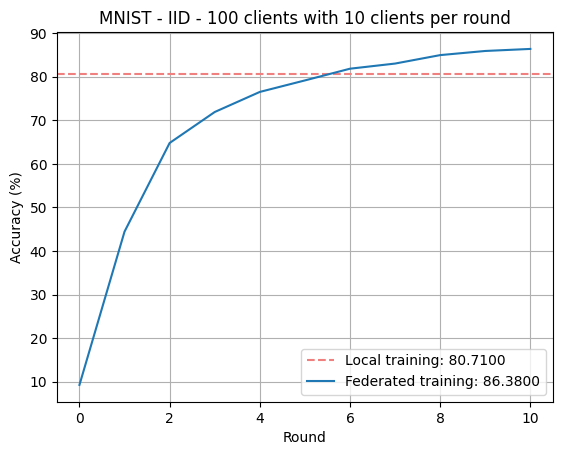

In [58]:
print(f"{history.metrics_centralized = }")

global_accuracy_centralised = history.metrics_centralized["accuracy"]
round = [data[0] for data in global_accuracy_centralised]
acc = [100.0 * data[1] for data in global_accuracy_centralised]

local = accuracy * 100
plt.axhline(
    y=local, label=f"Local training: {local:.4f}", linestyle="--", color="lightcoral"
)
plt.plot(round, acc, label=f"Federated training: {max(acc):.4f}")
plt.grid()
plt.ylabel("Accuracy (%)")
plt.xlabel("Round")
plt.legend()
plt.title("MNIST - IID - 100 clients with 10 clients per round")